# Kish Basin statistics

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt

# import matplotlib.patches as mpatches
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [3]:
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

## Read data layers

In [4]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [5]:
ds = fns.net_to_gross(ds)

In [6]:
ds

<xarray.Dataset> Size: 15MB
Dimensions:          (halite: 4, y: 237, x: 218)
Coordinates:
  * y                (y) float64 2kB 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x                (x) float64 2kB 6.966e+05 6.968e+05 ... 7.398e+05 7.4e+05
    spatial_ref      int64 8B 0
  * halite           (halite) <U8 128B 'Fylde' 'Mythop' 'Preesall' 'Rossall'
    crs              int64 8B 0
Data variables:
    BaseDepth        (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    Thickness        (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    TopDepth         (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    TopTWT           (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    TopDepthSeabed   (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    BaseDepthSeabed  (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    Bathymetry       (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    NetToGross       (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    ThicknessNet     (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan

In [7]:
ds.rio.crs

CRS.from_epsg(23029)

In [8]:
ds.rio.resolution()

(200.0, -200.0)

In [9]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [10]:
def plot_facet_maps(dat_xr, dat_extent, dat_crs):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    for v in dat_xr.data_vars:
        f = dat_xr[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(dat_crs)},
            xlim=(xmin_, xmax_),
            ylim=(ymin_, ymax_),
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(f.axs.flat):
            cx.add_basemap(
                axis, crs=dat_crs, source=basemap, attribution=False
            )
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
                )
        f.set_titles("{value}", weight="semibold")
        plt.show()

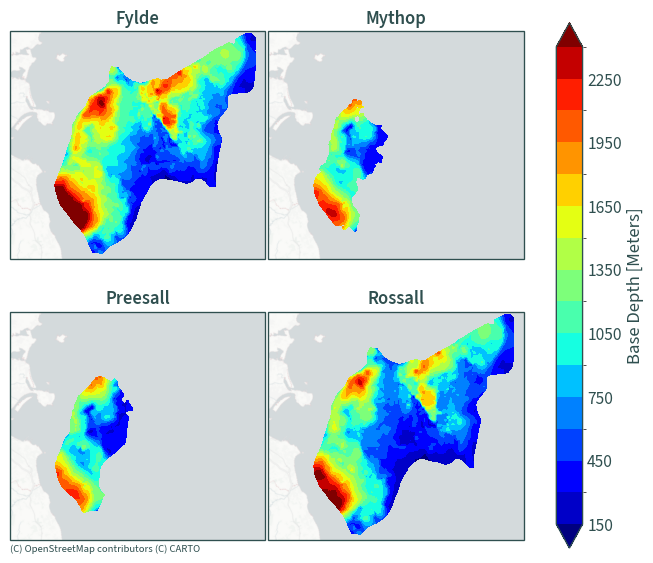

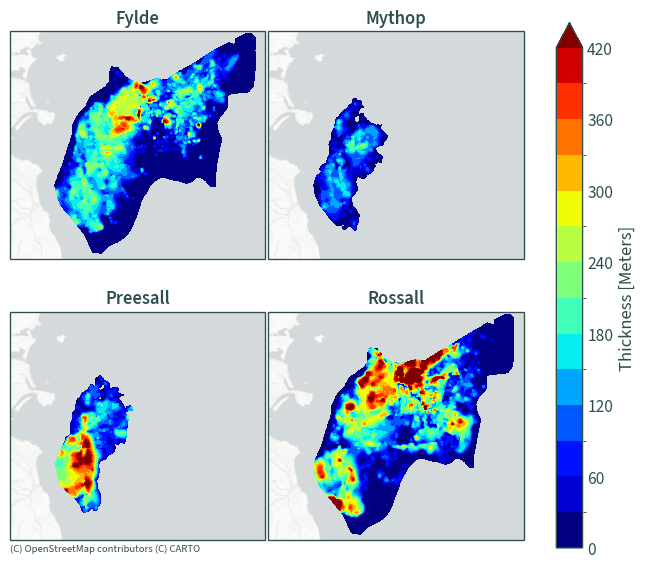

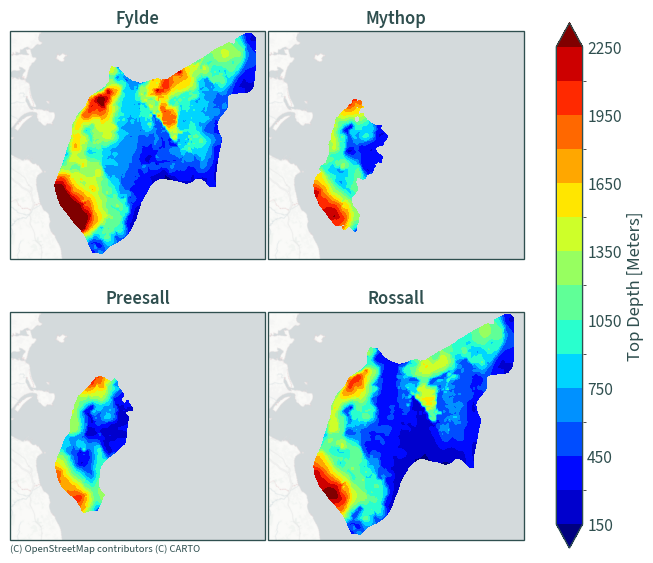

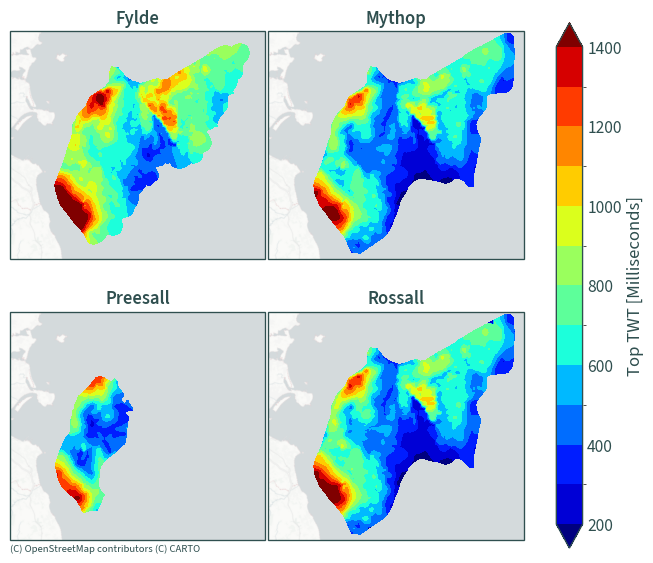

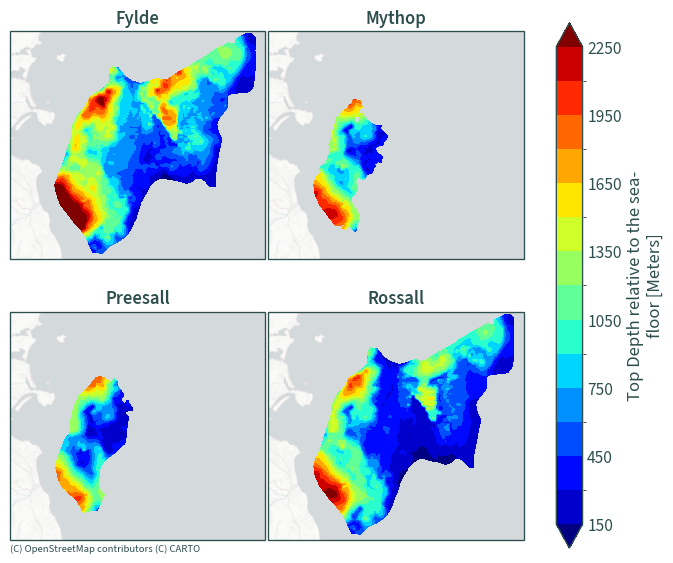

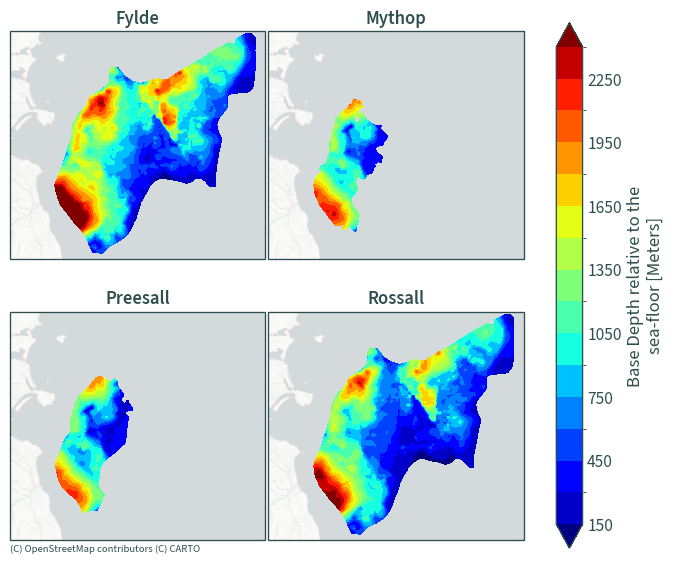

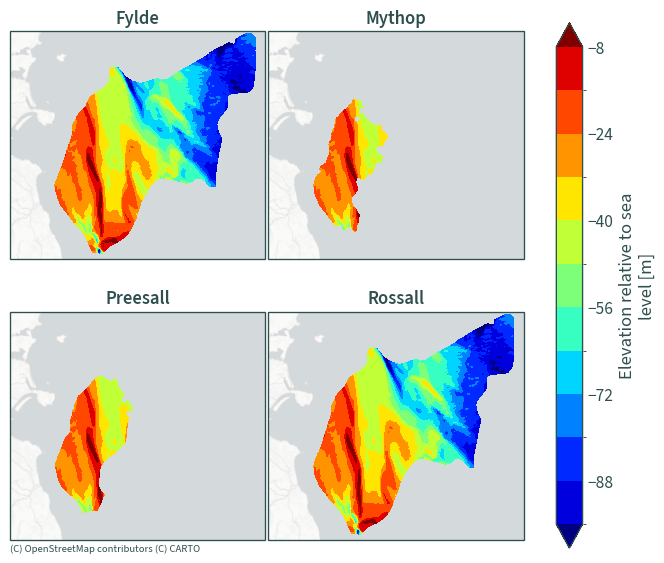

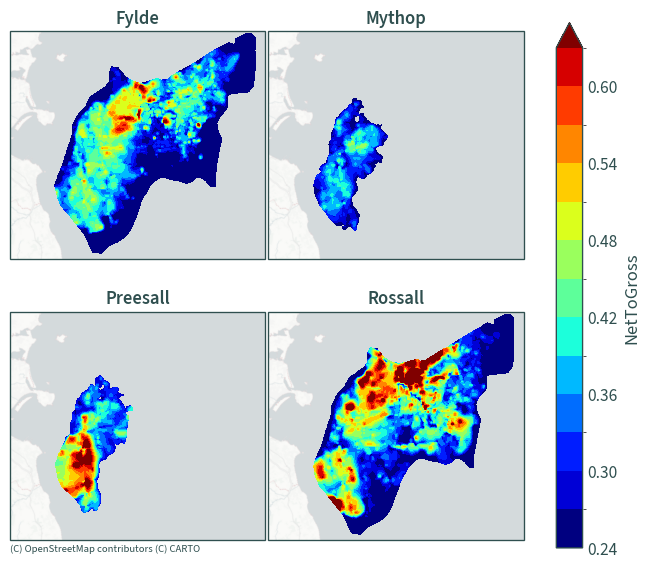

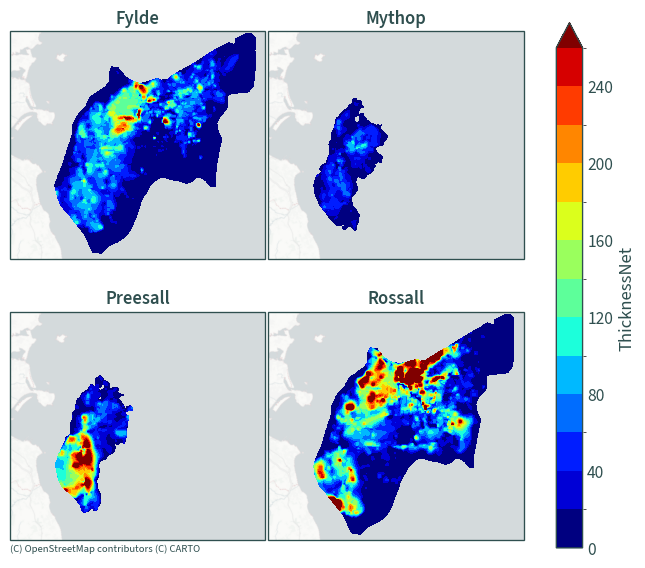

In [11]:
plot_facet_maps(ds, extent, rd.CRS)

## Stats

In [19]:
df = ds.to_dataframe()[list(ds.data_vars)]

In [20]:
df.describe()

,BaseDepth,Thickness,TopDepth,TopTWT,TopDepthSeabed,BaseDepthSeabed,Bathymetry,NetToGross,ThicknessNet
count,63868.000000,63456.000000,63868.000000,80386.000000,63868.000000,63868.000000,63868.000000,63456.000000,63456.000000
mean,1011.301702,112.835875,899.392295,653.242487,852.308746,964.218153,-47.083550,0.365550,52.781874
std,536.478279,113.380006,507.401263,259.464713,514.491483,543.935914,24.235226,0.102332,68.099619
min,120.324500,0.000000,120.324500,136.616000,69.237007,73.091809,-125.472397,0.261677,0.000000
25%,574.370900,4.344600,476.546675,468.859575,423.502166,517.393110,-66.155502,0.265696,1.154345
50%,952.930250,90.634850,818.911100,631.917300,766.899198,906.093512,-41.403992,0.345530,31.317073
75%,1334.956375,178.472675,1207.349725,776.623200,1162.222693,1298.014215,-26.248158,0.426796,76.171349
max,3512.489700,1111.067000,3273.030800,1911.048300,3234.948776,3475.165874,-2.961994,0.750000,833.300250


In [41]:
# max total thickness
ds.sum(dim="halite").to_dataframe()[["Thickness", "ThicknessNet"]].max()

Thickness       1333.783800
ThicknessNet     931.654692
dtype: float64

In [21]:
# surface area
shape = rd.halite_shape(dat_xr=ds)

In [23]:
print(f"Surface area: {shape.area[0]:.4E} m\N{SUPERSCRIPT TWO}")

Surface area: 1.0224E+09 m²


In [24]:
def plot_facet_maps_distr(
    dat_xr,
    dat_extent,
    dat_crs,
    v,
    levels,
    label,
):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds
    if levels:
        levels = sorted(levels)
    # legend_handles = []

    f = dat_xr[v].plot.contourf(
        col="halite",
        robust=True,
        levels=levels,
        cmap=sns.color_palette("flare", as_cmap=True),
        figsize=(6, 8.5),
        subplot_kws={"projection": ccrs.epsg(dat_crs)},
        xlim=(xmin_, xmax_),
        ylim=(ymin_, ymax_),
        cbar_kwargs={
            "location": "bottom",
            "aspect": 20,
            "shrink": 0.8,
            "pad": 0.07,
            "extendfrac": 0.2,
            "label": label,
            "format": lambda x, _: f"{x:,.0f}",
        },
        # add_colorbar=False,
        col_wrap=2,
    )

    # colours = [int(n * 255 / (len(levels) - 1)) for n in range(len(levels))]
    # for n, (level, colour) in enumerate(zip(levels, colours)):
    #     if n == 0:
    #         legend_handles.append(
    #             mpatches.Patch(
    #                 facecolor=sns.color_palette("flare", 256)[colour],
    #                 label=f"< {level}"
    #             )
    #         )
    #     elif n == len(levels) - 1:
    #         legend_handles.append(
    #             mpatches.Patch(
    #                 facecolor=sns.color_palette("flare", 256)[colour],
    #                 label=f"> {levels[n - 1]}"
    #             )
    #         )
    #     else:
    #         legend_handles.append(
    #             mpatches.Patch(
    #                 facecolor=sns.color_palette("flare", 256)[colour],
    #                 label=f"{levels[n - 1]}–{level}"
    #             )
    #         )

    # add a basemap
    basemap = cx.providers.CartoDB.PositronNoLabels
    for n, axis in enumerate(f.axs.flat):
        cx.add_basemap(axis, crs=dat_crs, source=basemap, attribution=False)
        # tick labels and attribution for basemap tiles
        if n in (0, 2):
            axis.gridlines(
                draw_labels={"left": "y"},
                color="none",
                yformatter=LatitudeFormatter(auto_hide=False, dms=True),
                ylabel_style={"rotation": 90},
                ylocs=[53.2, 53.4],
            )
        if n in (2, 3):
            axis.gridlines(
                draw_labels={"bottom": "x"},
                color="none",
                xformatter=LongitudeFormatter(auto_hide=False, dms=True),
                xlocs=[-6.15, -5.85, -5.55],
            )
        axis.gridlines(color="lightslategrey", alpha=0.25)
        if n == 3:
            axis.add_artist(
                ScaleBar(
                    1,
                    box_alpha=0,
                    location="lower right",
                    color="darkslategrey",
                    width_fraction=0.015,
                )
            )
        if n == 2:
            axis.text(
                xmin_ + 1000,
                ymin_ + 1000,
                basemap["attribution"],
                fontsize=8,
            )
    f.set_titles("{value}", weight="semibold")
    # plt.legend(
    #     bbox_to_anchor=(0.875, -0.12),
    #     title=label,
    #     handles=legend_handles,
    #     fontsize=11.5,
    #     ncols=3
    # )
    # if v == "ThicknessNet":
    #     plt.savefig(
    #         os.path.join("graphics", "fig_facet_thickness_ntg.jpg"),
    #         format="jpg",
    #         dpi=600,
    #     )
    plt.show()

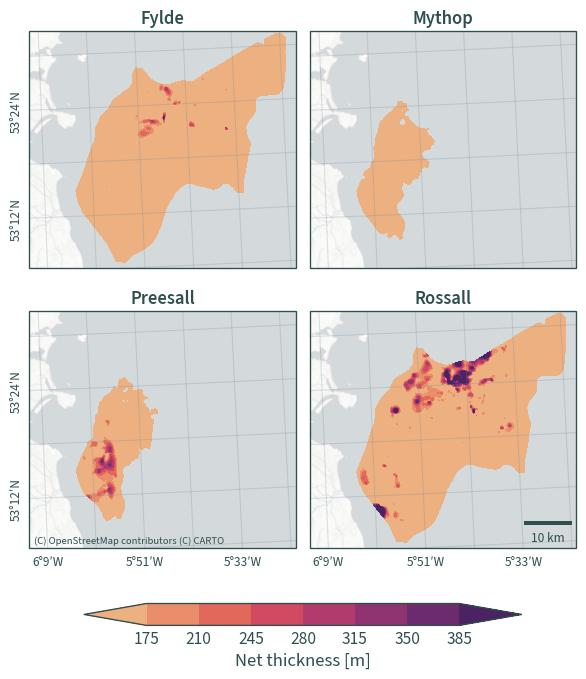

In [25]:
plot_facet_maps_distr(
    ds,
    extent,
    rd.CRS,
    "ThicknessNet",
    [85 + 35 * n + 90 for n in range(7)],
    "Net thickness [m]",
)

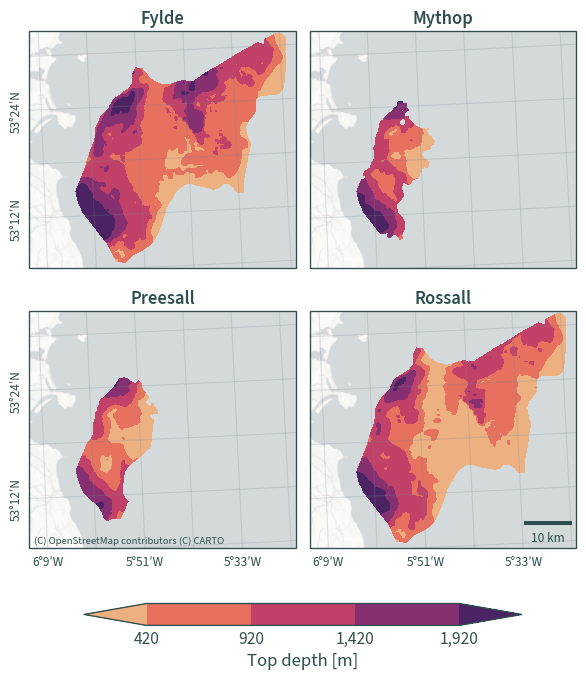

In [26]:
plot_facet_maps_distr(
    ds,
    extent,
    rd.CRS,
    "TopDepthSeabed",
    [500 - 80, 1000 - 80, 1500 - 80, 2000 - 80],
    "Top depth [m]",
)

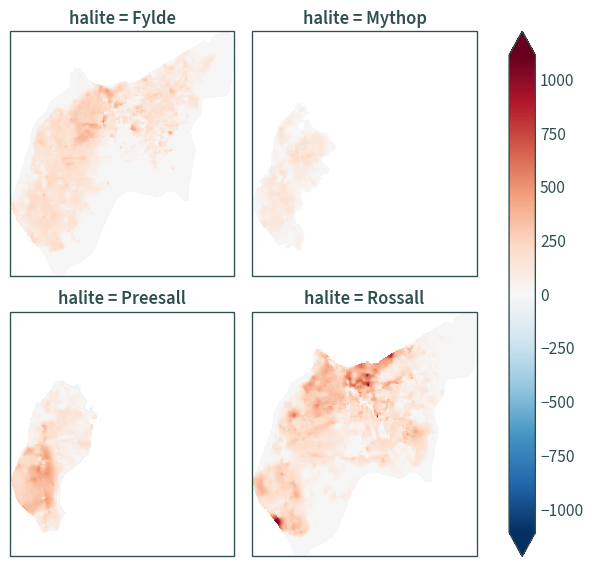

In [27]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot(
    col="halite",
    col_wrap=2,
    extend="both",
    subplot_kws={"projection": ccrs.epsg(rd.CRS)},
)
plt.show()

In [28]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [29]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679